<a href="https://colab.research.google.com/github/neddanedda/PyTorch_course/blob/main/Flowers_five_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers Five Classes from Kaggle


## Installing Kaggle and downloading the data

In [2]:
! pip install -q kaggle

In [2]:
# from google.colab import files

In [4]:
import os
os.getcwd()

'/Users/neddacecchinato/Documents/Python/PyTorch_course'

In [6]:
os.chdir('../flowers_five_classes')
os.getcwd()

'/Users/neddacecchinato/Documents/Python/flowers_five_classes'

In [8]:
! kaggle datasets download -d lara311/flowers-five-classes

Dataset URL: https://www.kaggle.com/datasets/lara311/flowers-five-classes
License(s): apache-2.0
flowers-five-classes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
!unzip flowers-five-classes.zip;

Archive:  flowers-five-classes.zip
replace train/daisy/10140303196_b88d3d6cec.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Useful Functions


In [10]:
import random
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from pathlib import Path
from timeit import default_timer as timer
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
# from tqdm.auto import tqdm

In [12]:
#check for gpu
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    device = "mps"
    print (x)
else:
    device = "cpu"
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [14]:
# synchronize time
torch.mps.synchronize()

In [16]:
from tqdm.notebook import tqdm

### Train step function

In [22]:
# %%writefile train_step.py
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               device: str ="cpu"):
    model.train()
    
    train_loss = 0
    train_acc = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # print(X.shape)
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)
        # if batch % 10 == 0:
        #   print(f"Processed {batch} batches")

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

In [24]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model_0.parameters(),
#                              lr=0.01)


In [26]:
# train_step(model_0,
#            train_dataloader,
#            optimizer,
#            loss_fn)

### Test step function

In [29]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: str ="cpu"):
    model.eval()
    
    test_loss = 0
    test_acc = 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y)
            y_pred_prob = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_prob == y).sum() / len(y)
            
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [31]:
# test_step(model_0,
#           test_dataloader,
#           loss_fn)

### Train loop function

In [34]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module =nn.CrossEntropyLoss(),
          epochs: int =5,
          device: str="cpu"):
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model,
                                           train_dataloader,
                                           optimizer,
                                           loss_fn,
                                           device=device)
        test_loss, test_acc = test_step(model,
                                        test_dataloader,
                                        loss_fn,
                                        device=device)
    
        # if epochs <= 10:
        print(f"Epoch: {epoch+1}")
        print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")
        # else:
        #     if epoch % 5 == 0:
        #         print(f"Epoch: {epoch+1}")
        #         print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
    
    return results


### Confusion matrix function

In [37]:
# confusion matrix
try:
    import torchmetrics
except:
    !pip install -q torchmetrics
    import torchmetrics

try:
    import mlxtend
except:
    !pip install -q mlxtend
    import mlxtend

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [39]:
def confusion_matrix_plot(model: nn.Module,
                          test_dataloader: torch.utils.data.DataLoader,
                          class_names: list):
    # calculating the predictions on the test dataset
    model.eval()
    with torch.inference_mode():
        y_pred = []
        y_true = []
        for X, y in test_dataloader:
            y_logit = model(X)
            y_predictions = torch.softmax(y_logit, dim=1).argmax(dim=1)
            y_pred.append(y_predictions)
            y_true.append(y)
        
        y_pred = torch.cat(y_pred)
        y_true = torch.cat(y_true)
    
    # calculating the confusion matrix
    confmat = ConfusionMatrix(task='multiclass',num_classes=len(class_names))
    confmat_tensor = confmat(preds=y_pred,
                             target=y_true).numpy()
    
    plot_confusion_matrix(confmat_tensor, class_names=class_names);


### Plotting model results

In [42]:
def plot_model_results(results: pd.DataFrame,
                       figsize: int=12):
    """ plotting train and test loss and accuracy over several epochs

    Args:
        results: a pd.DataFrame with 4 columns: train_loss, train_acc, test_loo, test_acc
        figsize1: figure width
        figsize2: figure height
    """
    
    plt.figure(figsize=(figsize, figsize))
    plt.subplot(2, 2, 1)
    plt.plot(range(len(results["train_loss"])), results["train_loss"])
    plt.plot(range(len(results["train_loss"])), results["test_loss"])
    plt.title("Loss")
    
    plt.subplot(2, 2, 2)
    plt.plot(range(len(results["train_loss"])), results["train_acc"])
    plt.plot(range(len(results["train_loss"])), results["test_acc"])
    plt.title("Accuracy")
    
    plt.subplot(2, 2, 3)
    plt.scatter(results["train_loss"], results["train_acc"])
    plt.title("Train loss vs train accuracy")
    
    plt.subplot(2, 2, 4)
    plt.scatter(results["test_loss"], results["test_acc"])
    plt.title("Test loss vs test accuracy");


### Saving model

In [45]:
def save_model(model: nn.Module,
               model_path: str):
    torch.save(obj=model.state_dict(),
               f=path(model_path))


## Importing the data and exploring

In [59]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [61]:
data = datasets.ImageFolder(root="train",
                            transform=data_transform, # transform for the data
                            target_transform=None)

In [63]:
class_names = data.classes

In [65]:
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [67]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [68]:
len(train_data), len(test_data)

(2201, 551)

### Plotting some random images

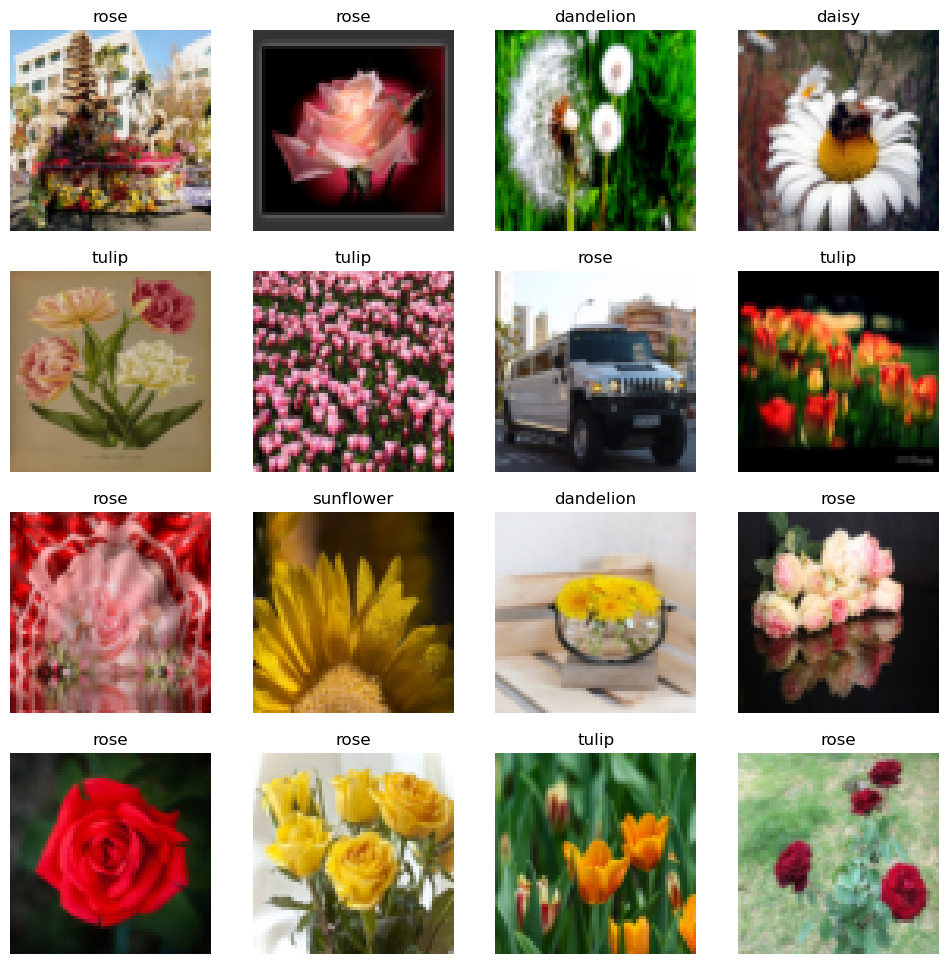

In [57]:
plt.figure(figsize=(12, 12))

for j in range(16):
  plt.subplot(4, 4, j+1)
  random_image = random.choice(range(len(test_data)))
  plt.imshow(train_data[random_image][0].permute(1, 2, 0))
  plt.title(class_names[train_data[random_image][1]])
  plt.axis(False);

### Creating dataloader for the model

In [71]:
# creating dataloader
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

In [72]:
len(train_dataloader)

69

In [75]:
train_data[0]

(tensor([[[0.0588, 0.0627, 0.0745,  ..., 0.0706, 0.0706, 0.0627],
          [0.0627, 0.0706, 0.0784,  ..., 0.0745, 0.0745, 0.0745],
          [0.0667, 0.0745, 0.0863,  ..., 0.0784, 0.0784, 0.0824],
          ...,
          [0.0824, 0.2000, 0.5961,  ..., 0.1686, 0.1529, 0.1647],
          [0.0784, 0.1294, 0.5373,  ..., 0.1804, 0.1529, 0.1608],
          [0.0745, 0.1098, 0.5137,  ..., 0.2118, 0.1608, 0.1608]],
 
         [[0.0667, 0.0745, 0.0863,  ..., 0.0706, 0.0706, 0.0667],
          [0.0706, 0.0784, 0.0902,  ..., 0.0745, 0.0745, 0.0784],
          [0.0784, 0.0863, 0.0980,  ..., 0.0784, 0.0784, 0.0824],
          ...,
          [0.0863, 0.2314, 0.7451,  ..., 0.1882, 0.1647, 0.1922],
          [0.0784, 0.1490, 0.6667,  ..., 0.2078, 0.1686, 0.1882],
          [0.0745, 0.1176, 0.6314,  ..., 0.2431, 0.1804, 0.1843]],
 
         [[0.0471, 0.0510, 0.0588,  ..., 0.0627, 0.0549, 0.0549],
          [0.0510, 0.0549, 0.0627,  ..., 0.0667, 0.0627, 0.0627],
          [0.0549, 0.0627, 0.0706,  ...,

In [76]:
# next(enumerate(train_dataloader))[0]

## Tiny VGG architecture

In [78]:
class TinyVGG(nn.Module):
  def __init__(self,
               in_feature: int,
               hidden_units: int,
               output_features: int,
               remaining_dimensions: int):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_feature,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*remaining_dimensions*remaining_dimensions,
                  out_features=output_features)
    )

  def forward(self, x):
    # x = self.conv_block1(x)
    # print(x.shape)
    # x = self.conv_block2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    # x = self.classifier1(x)
    # return(x)
    return self.classifier(
        self.conv_block2(self.conv_block1(x)))


In [92]:
model_0 = TinyVGG(3, 20, len(class_names), 13)#.to(device)
next(model_0.parameters()).device

device(type='cpu')

## Model 0: Tiny VGG with 10 hidden units

In [83]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [85]:
summary(model_0, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 5]                   --
├─Sequential: 1-1                        [32, 20, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 20, 62, 62]          560
│    └─ReLU: 2-2                         [32, 20, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 20, 60, 60]          3,620
│    └─ReLU: 2-4                         [32, 20, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 20, 30, 30]          --
├─Sequential: 1-2                        [32, 20, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 20, 28, 28]          3,620
│    └─ReLU: 2-7                         [32, 20, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 20, 26, 26]          3,620
│    └─ReLU: 2-9                         [32, 20, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 20, 13, 13]          --
├─Seq

In [95]:
model_0 = TinyVGG(3, 10, 5, 13)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.01)

In [91]:
m0_start_time = timer()
model_0_results = train(model_0,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=10)
m0_end_time = timer()
print((m0_end_time-m0_start_time))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60483 | Train acc: 0.23466 | Test loss: 1.60011 | Test acc: 0.22396
Epoch: 2
Train loss: 1.60467 | Train acc: 0.23478 | Test loss: 1.59950 | Test acc: 0.22396
Epoch: 3
Train loss: 1.60448 | Train acc: 0.23491 | Test loss: 1.59938 | Test acc: 0.22396
Epoch: 4
Train loss: 1.60415 | Train acc: 0.23466 | Test loss: 1.59933 | Test acc: 0.22396
Epoch: 5
Train loss: 1.60389 | Train acc: 0.23504 | Test loss: 1.59860 | Test acc: 0.22396
Epoch: 6
Train loss: 1.60361 | Train acc: 0.23453 | Test loss: 1.59782 | Test acc: 0.22396
Epoch: 7
Train loss: 1.60301 | Train acc: 0.23491 | Test loss: 1.59683 | Test acc: 0.22396
Epoch: 8
Train loss: 1.60172 | Train acc: 0.23478 | Test loss: 1.59645 | Test acc: 0.22396
Epoch: 9
Train loss: 1.60029 | Train acc: 0.23516 | Test loss: 1.59362 | Test acc: 0.22396
Epoch: 10
Train loss: 1.59688 | Train acc: 0.23413 | Test loss: 1.58744 | Test acc: 0.22396
-0.8305307722165405


In [ ]:
model_0_results1 = train(model_0,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

In [ ]:
import pandas as pd
model_0_results_total = pd.concat([pd.DataFrame(model_0_results),
                                   pd.DataFrame(model_0_results1)])
model_0_results_total.head()

,train_loss,train_acc,test_loss,test_acc
0,1.607225,0.219112,1.601365,0.250000
1,1.604675,0.226540,1.598669,0.273727
2,1.603538,0.241667,1.597231,0.250000
3,1.602575,0.224457,1.595317,0.278935
4,1.600172,0.240036,1.594273,0.248264


### Evaluating `model_0`

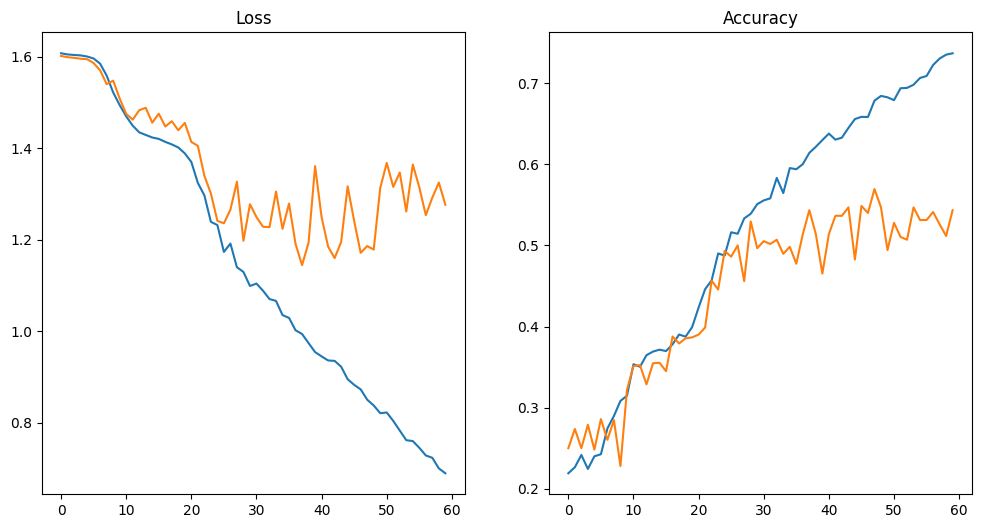

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["train_loss"])
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["test_loss"])
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["train_acc"])
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["test_acc"])
plt.title("Accuracy");


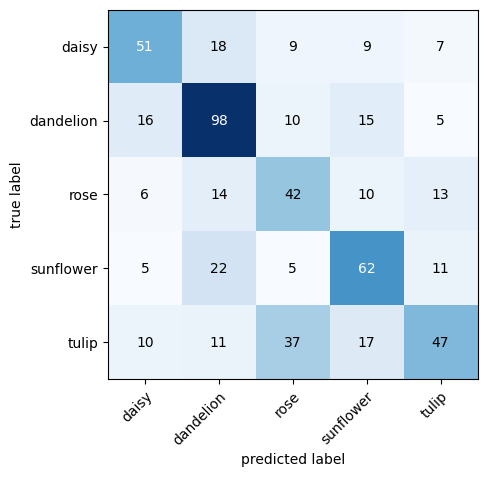

In [ ]:
confusion_matrix_plot(model_0,
                      test_dataloader,
                      class_names)

## Model 1: Tiny VGG with 20 hidden units

In [ ]:
model_1 = TinyVGG(3, 20, 5, 13)

In [ ]:
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.01)

In [ ]:
model_1_results = train(model_1,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6082 | train_acc: 0.2124 | test_loss: 1.6020 | test_acc: 0.2500
Epoch: 2 | train_loss: 1.6044 | train_acc: 0.2273 | test_loss: 1.5967 | test_acc: 0.2535
Epoch: 3 | train_loss: 1.6027 | train_acc: 0.2402 | test_loss: 1.5947 | test_acc: 0.2500
Epoch: 4 | train_loss: 1.6001 | train_acc: 0.2289 | test_loss: 1.5912 | test_acc: 0.2517
Epoch: 5 | train_loss: 1.5950 | train_acc: 0.2511 | test_loss: 1.5846 | test_acc: 0.2830
Epoch: 6 | train_loss: 1.5839 | train_acc: 0.2725 | test_loss: 1.5644 | test_acc: 0.2812
Epoch: 7 | train_loss: 1.5511 | train_acc: 0.3090 | test_loss: 1.5301 | test_acc: 0.3108


In [ ]:
model_1_results1 = train(model_1,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2948 | train_acc: 0.4280 | test_loss: 1.3208 | test_acc: 0.4167
Epoch: 2 | train_loss: 1.2546 | train_acc: 0.4529 | test_loss: 1.3016 | test_acc: 0.4167
Epoch: 3 | train_loss: 1.2250 | train_acc: 0.4734 | test_loss: 1.2459 | test_acc: 0.4531
Epoch: 4 | train_loss: 1.2013 | train_acc: 0.4814 | test_loss: 1.2107 | test_acc: 0.4965
Epoch: 5 | train_loss: 1.1797 | train_acc: 0.4937 | test_loss: 1.3214 | test_acc: 0.4317
Epoch: 6 | train_loss: 1.1869 | train_acc: 0.4923 | test_loss: 1.2356 | test_acc: 0.4757
Epoch: 7 | train_loss: 1.1538 | train_acc: 0.5178 | test_loss: 1.2253 | test_acc: 0.4844
Epoch: 8 | train_loss: 1.1405 | train_acc: 0.5230 | test_loss: 1.2314 | test_acc: 0.4809
Epoch: 9 | train_loss: 1.1292 | train_acc: 0.5252 | test_loss: 1.2431 | test_acc: 0.5035
Epoch: 10 | train_loss: 1.1261 | train_acc: 0.5364 | test_loss: 1.2948 | test_acc: 0.4427
Epoch: 11 | train_loss: 1.1289 | train_acc: 0.5265 | test_loss: 1.2448 | test_acc: 0.4826
Epoch: 12 | train_l

In [ ]:
model_1_results_total = pd.concat([pd.DataFrame(model_1_results),
                                   pd.DataFrame(model_1_results1)])

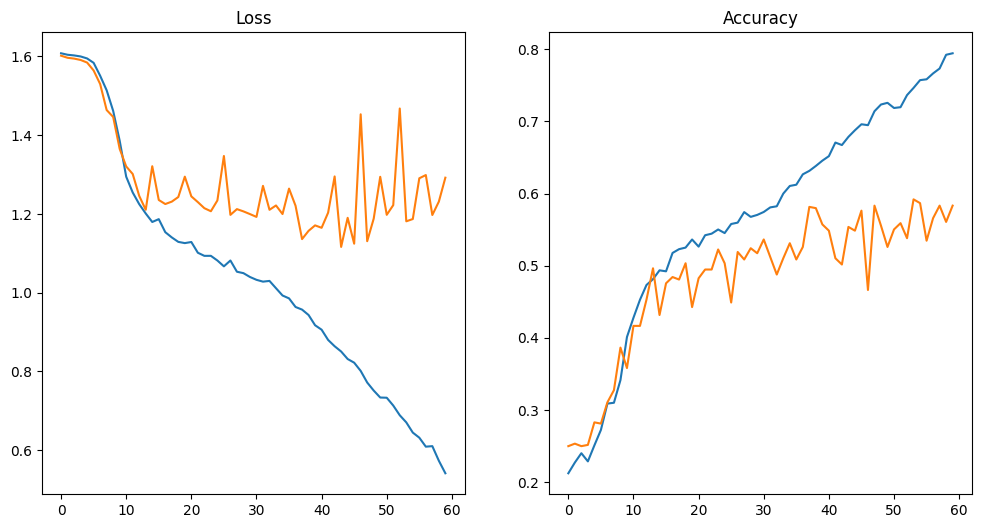

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["train_loss"])
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["test_loss"])
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["train_acc"])
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["test_acc"])
plt.title("Accuracy");


## Model 2: Tiny VGG with 40 hidden units

In [ ]:
model_2 = TinyVGG(3, 40, 5, 13)

In [ ]:
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [ ]:
model_2_results = train(model_2,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6059 | train_acc: 0.2096 | test_loss: 1.5985 | test_acc: 0.2998
Epoch: 2 | train_loss: 1.5990 | train_acc: 0.2330 | test_loss: 1.5912 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.5829 | train_acc: 0.2572 | test_loss: 1.5686 | test_acc: 0.2836
Epoch: 4 | train_loss: 1.5233 | train_acc: 0.3103 | test_loss: 1.4757 | test_acc: 0.3466
Epoch: 5 | train_loss: 1.4309 | train_acc: 0.3772 | test_loss: 1.3858 | test_acc: 0.4097
Epoch: 6 | train_loss: 1.3553 | train_acc: 0.4032 | test_loss: 1.4406 | test_acc: 0.3663
Epoch: 7 | train_loss: 1.2923 | train_acc: 0.4456 | test_loss: 1.3123 | test_acc: 0.4410
Epoch: 8 | train_loss: 1.2455 | train_acc: 0.4706 | test_loss: 1.2417 | test_acc: 0.4896


In [ ]:
model_2_results1 = train(model_2,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1627 | train_acc: 0.5184 | test_loss: 1.2308 | test_acc: 0.5000
Epoch: 2 | train_loss: 1.1573 | train_acc: 0.5137 | test_loss: 1.2569 | test_acc: 0.5017
Epoch: 3 | train_loss: 1.1359 | train_acc: 0.5193 | test_loss: 1.2151 | test_acc: 0.4965
Epoch: 4 | train_loss: 1.1367 | train_acc: 0.5260 | test_loss: 1.2501 | test_acc: 0.4774
Epoch: 5 | train_loss: 1.1115 | train_acc: 0.5373 | test_loss: 1.1880 | test_acc: 0.5330
Epoch: 6 | train_loss: 1.1072 | train_acc: 0.5476 | test_loss: 1.1922 | test_acc: 0.5139
Epoch: 7 | train_loss: 1.0996 | train_acc: 0.5495 | test_loss: 1.2418 | test_acc: 0.5017
Epoch: 8 | train_loss: 1.0936 | train_acc: 0.5473 | test_loss: 1.2005 | test_acc: 0.5260
Epoch: 9 | train_loss: 1.0797 | train_acc: 0.5610 | test_loss: 1.1698 | test_acc: 0.5226
Epoch: 10 | train_loss: 1.0726 | train_acc: 0.5659 | test_loss: 1.2034 | test_acc: 0.5139
Epoch: 11 | train_loss: 1.0676 | train_acc: 0.5838 | test_loss: 1.2063 | test_acc: 0.5104
Epoch: 12 | train_l

In [ ]:
model_2_results_total = pd.concat([pd.DataFrame(model_2_results),
                                   pd.DataFrame(model_2_results1)])

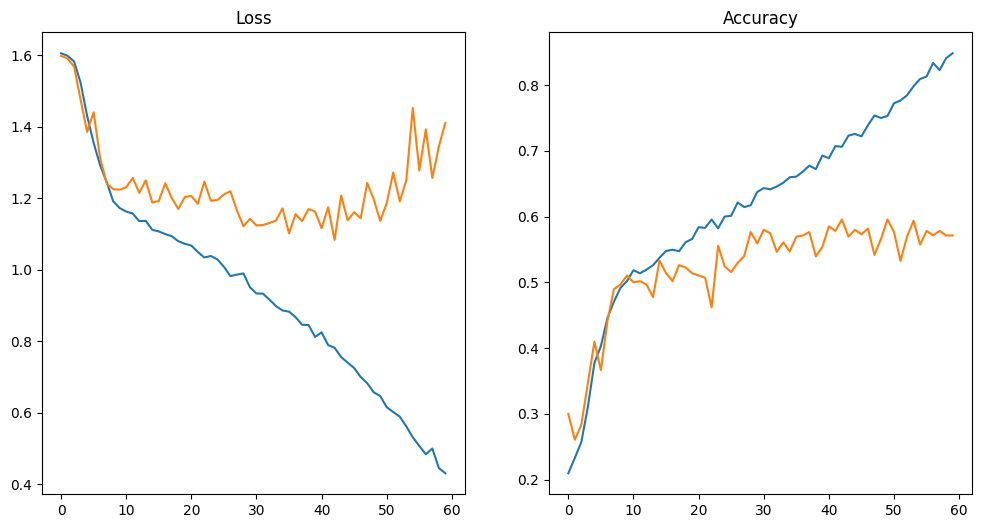

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["train_loss"])
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["test_loss"])
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["train_acc"])
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["test_acc"])
plt.title("Accuracy");


## Comparing Tiny VGG models with different hidden units

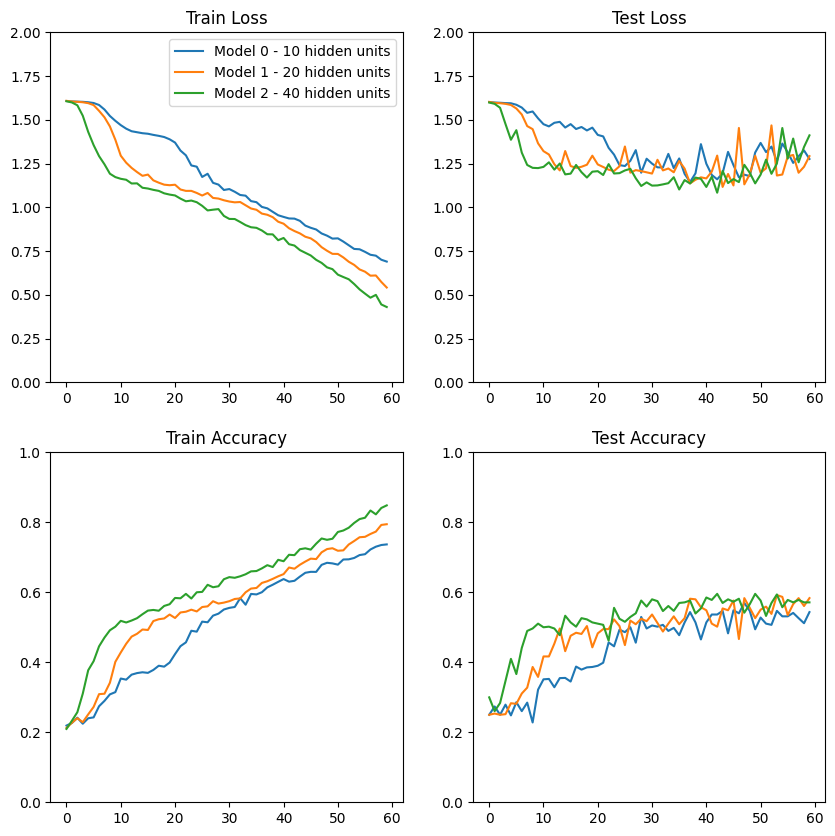

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["train_loss"], label="Model 0 - 10 hidden units")
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["train_loss"], label="Model 1 - 20 hidden units")
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["train_loss"], label="Model 2 - 40 hidden units")
plt.legend()
plt.ylim(0, 2)
plt.title("Train Loss")

plt.subplot(2, 2, 2)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["test_loss"])
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["test_loss"])
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["test_loss"])
plt.ylim(0, 2)
plt.title("Test Loss")

plt.subplot(2, 2, 3)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["train_acc"])
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["train_acc"])
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["train_acc"])
plt.ylim(0, 1)
plt.title("Train Accuracy");

plt.subplot(2, 2, 4)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["test_acc"])
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["test_acc"])
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["test_acc"])
plt.ylim(0, 1)
plt.title("Test Accuracy");

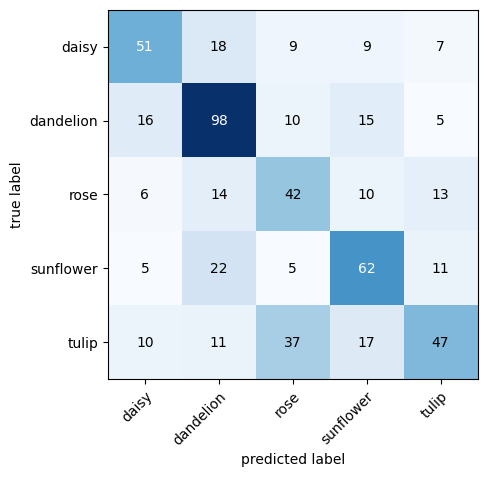

In [ ]:
confusion_matrix_plot(model_0,
                      test_dataloader,
                      class_names)

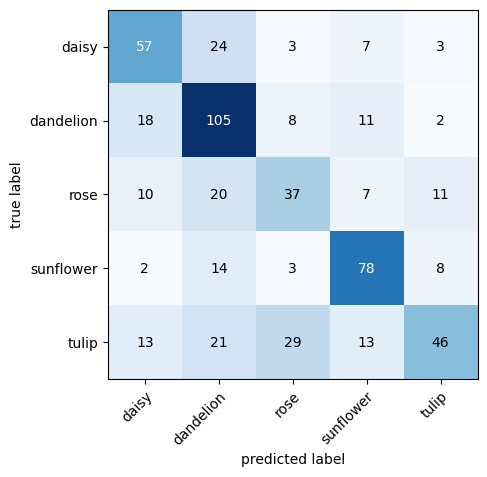

In [ ]:
confusion_matrix_plot(model_1,
                      test_dataloader,
                      class_names)

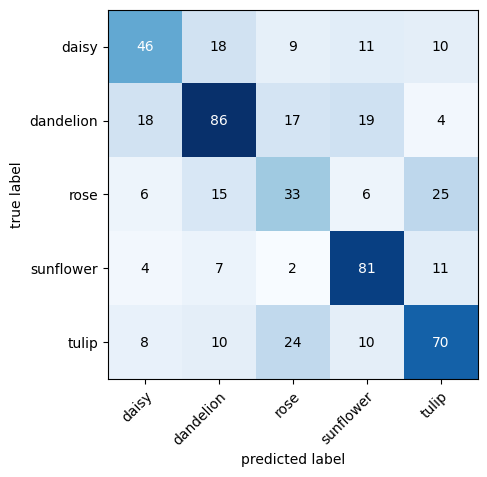

In [ ]:
confusion_matrix_plot(model_2,
                      test_dataloader,
                      class_names)

## VGG-11 architecture

https://www.geeksforgeeks.org/vgg-16-cnn-model/

In [215]:
class VGG11architecture(nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Conv2d(in_channels=64, out_channels=64,
            #           kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2))
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Conv2d(in_channels=128, out_channels=128,
            #           kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2))
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Conv2d(in_channels=256, out_channels=256,
            #           kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2))
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Conv2d(in_channels=512, out_channels=512,
            #           kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2))
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Conv2d(in_channels=512, out_channels=512,
            #           kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=5)
            # nn.ReLU()
        )
        
    def forward(self, x):
        return self.classifier(
            self.convblock5(
                self.convblock4(
                    self.convblock3(
                        self.convblock2(
                            self.convblock1(x))))))


In [217]:
# import torchvision
# torchvision.models.vgg11()

### Importing data

In [219]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [220]:
data = datasets.ImageFolder(root="train",
                            transform=data_transform, # transform for the data
                            target_transform=None)

In [221]:
class_names = data.classes

In [222]:
train_data, test_data = train_test_split(data, test_size=0.2)
# other_data, train_data = train_test_split(train_data, test_size=0.20)

In [223]:
len(train_data), len(test_data)

(2201, 551)

In [224]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
len(train_dataloader)

69

### Summary of finetuning exercises

The problem is always that the model is hugely underfitting with an accuracy below 25%. I only trained the model on a smaller dataset to see how it was doing:
* I tried to increase the size of the dataset but did not see an improvement
* I tried different learning rates and mixture of learning rates: see https://towardsdatascience.com/https-medium-com-dashingaditya-rakhecha-understanding-learning-rate-dd5da26bb6de
* I tried to train for longer
* I tried to use the entire dataset

Loss always gets stucked at around *1.6*.

So far nothing gave significant improvements

### Model 3: learning rate 0.01

In [383]:
model_3 = VGG11architecture().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.01)

In [387]:
m3_start_time = timer()
model_3_results = train(model_3,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=1,
                        device=device)
m3_end_time = timer()
print((m3_end_time-m3_start_time)/60)

In [204]:
pd.DataFrame(model_3_results)

,train_loss,train_acc,test_loss,test_acc
0,1.608466,0.235236,1.607604,0.223462
1,1.606504,0.239638,1.606109,0.223462
2,1.605205,0.239638,1.606823,0.211062
3,1.604236,0.240145,1.606188,0.217262
4,1.603766,0.239511,1.607506,0.204861


In [206]:
m3_start_time = timer()
# model_3_results = []
model_3_results = pd.DataFrame()

for cycle in range(5):
    optimizer = torch.optim.SGD(model_3.parameters(),
                                lr=0.01)
    model_3_results0 = train(model_3,
                             train_dataloader,
                             test_dataloader,
                             optimizer,
                             epochs=5,
                             device=device)
    optimizer = torch.optim.SGD(model_3.parameters(),
                                lr=0.005)
    model_3_results1 = train(model_3,
                             train_dataloader,
                             test_dataloader,
                             optimizer,
                             epochs=5,
                             device=device)
    optimizer = torch.optim.SGD(model_3.parameters(),
                                lr=0.001)
    model_3_results2 = train(model_3,
                             train_dataloader,
                             test_dataloader,
                             optimizer,
                             epochs=5,
                             device=device)
    model_3_results = pd.concat([model_3_results,
                                 pd.DataFrame(model_3_results0),
                                 pd.DataFrame(model_3_results1),
                                 pd.DataFrame(model_3_results2)])

m3_end_time = timer()
print((m3_end_time-m3_start_time)/60)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60329 | Train acc: 0.23964 | Test loss: 1.60501 | Test acc: 0.21726


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60249 | Train acc: 0.23976 | Test loss: 1.60638 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60224 | Train acc: 0.24027 | Test loss: 1.60059 | Test acc: 0.22966


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60265 | Train acc: 0.23938 | Test loss: 1.60655 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60229 | Train acc: 0.23976 | Test loss: 1.60560 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60217 | Train acc: 0.24040 | Test loss: 1.60649 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60237 | Train acc: 0.23976 | Test loss: 1.60558 | Test acc: 0.22346


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60251 | Train acc: 0.23951 | Test loss: 1.60668 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60229 | Train acc: 0.23976 | Test loss: 1.60935 | Test acc: 0.20486


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60246 | Train acc: 0.23976 | Test loss: 1.60372 | Test acc: 0.21726


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60214 | Train acc: 0.24078 | Test loss: 1.60446 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60219 | Train acc: 0.24040 | Test loss: 1.60766 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60248 | Train acc: 0.24002 | Test loss: 1.60317 | Test acc: 0.22346


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60241 | Train acc: 0.23964 | Test loss: 1.60451 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60224 | Train acc: 0.24027 | Test loss: 1.60414 | Test acc: 0.22346
68.89986470695003


In [175]:
m3_start_time = timer()
for cycle in range(5):
    optimizer = torch.optim.SGD(model_3.parameters(),
                                lr=0.01)
    model_3_results0 = train(model_3,
                             train_dataloader,
                             test_dataloader,
                             optimizer,
                             epochs=5,
                             device=device)
    optimizer = torch.optim.SGD(model_3.parameters(),
                                lr=0.005)
    model_3_results1 = train(model_3,
                             train_dataloader,
                             test_dataloader,
                             optimizer,
                             epochs=5,
                             device=device)
    optimizer = torch.optim.SGD(model_3.parameters(),
                                lr=0.001)
    model_3_results2 = train(model_3,
                             train_dataloader,
                             test_dataloader,
                             optimizer,
                             epochs=5,
                             device=device)
    model_3_results = pd.concat([model_3_results,
                                 pd.DataFrame(model_3_results0),
                                 pd.DataFrame(model_3_results1),
                                 pd.DataFrame(model_3_results2)])

m3_end_time = timer()
print((m3_end_time-m3_start_time)/60)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59939 | Train acc: 0.24816 | Test loss: 1.58179 | Test acc: 0.29688


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59914 | Train acc: 0.24737 | Test loss: 1.57939 | Test acc: 0.30729


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59929 | Train acc: 0.24790 | Test loss: 1.58453 | Test acc: 0.28125


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59899 | Train acc: 0.24816 | Test loss: 1.57523 | Test acc: 0.30729


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59916 | Train acc: 0.24711 | Test loss: 1.57705 | Test acc: 0.32292


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59884 | Train acc: 0.24816 | Test loss: 1.58313 | Test acc: 0.29688


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59914 | Train acc: 0.24842 | Test loss: 1.58006 | Test acc: 0.29167


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59937 | Train acc: 0.24764 | Test loss: 1.58014 | Test acc: 0.30208


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59887 | Train acc: 0.24869 | Test loss: 1.57883 | Test acc: 0.30208


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59954 | Train acc: 0.24737 | Test loss: 1.58047 | Test acc: 0.29167


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59904 | Train acc: 0.24790 | Test loss: 1.57750 | Test acc: 0.30729


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59956 | Train acc: 0.24711 | Test loss: 1.57561 | Test acc: 0.30729


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59936 | Train acc: 0.24816 | Test loss: 1.57355 | Test acc: 0.30729


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59911 | Train acc: 0.24737 | Test loss: 1.57715 | Test acc: 0.30729


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59908 | Train acc: 0.24764 | Test loss: 1.57454 | Test acc: 0.31250
15.965798085416706


In [179]:
train_data, test_data = train_test_split(data, test_size=0.10)
other_data, train_data = train_test_split(train_data, test_size=0.40)
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
len(train_dataloader)

31

In [181]:
m3_start_time = timer()
for cycle in range(5):
    optimizer = torch.optim.SGD(model_3.parameters(),
                                lr=0.01)
    model_3_results0 = train(model_3,
                             train_dataloader,
                             test_dataloader,
                             optimizer,
                             epochs=5,
                             device=device)
    optimizer = torch.optim.SGD(model_3.parameters(),
                                lr=0.005)
    model_3_results1 = train(model_3,
                             train_dataloader,
                             test_dataloader,
                             optimizer,
                             epochs=5,
                             device=device)
    optimizer = torch.optim.SGD(model_3.parameters(),
                                lr=0.001)
    model_3_results2 = train(model_3,
                             train_dataloader,
                             test_dataloader,
                             optimizer,
                             epochs=5,
                             device=device)
    model_3_results = pd.concat([model_3_results,
                                 pd.DataFrame(model_3_results0),
                                 pd.DataFrame(model_3_results1),
                                 pd.DataFrame(model_3_results2)])

m3_end_time = timer()
print((m3_end_time-m3_start_time)/60)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60470 | Train acc: 0.23211 | Test loss: 1.59476 | Test acc: 0.27431


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60418 | Train acc: 0.23205 | Test loss: 1.59566 | Test acc: 0.27639


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60395 | Train acc: 0.23225 | Test loss: 1.59669 | Test acc: 0.27431


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60411 | Train acc: 0.23221 | Test loss: 1.59835 | Test acc: 0.27222


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60393 | Train acc: 0.23215 | Test loss: 1.59767 | Test acc: 0.27014


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60384 | Train acc: 0.23211 | Test loss: 1.59602 | Test acc: 0.28472


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60402 | Train acc: 0.23208 | Test loss: 1.59839 | Test acc: 0.27639


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60390 | Train acc: 0.23208 | Test loss: 1.59917 | Test acc: 0.27014


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60381 | Train acc: 0.23215 | Test loss: 1.59699 | Test acc: 0.27639


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60397 | Train acc: 0.23208 | Test loss: 1.59802 | Test acc: 0.27431


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60390 | Train acc: 0.23202 | Test loss: 1.59752 | Test acc: 0.28056


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60381 | Train acc: 0.23205 | Test loss: 1.59751 | Test acc: 0.28056


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60390 | Train acc: 0.23208 | Test loss: 1.59850 | Test acc: 0.27431


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60386 | Train acc: 0.23211 | Test loss: 1.59927 | Test acc: 0.27431


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60381 | Train acc: 0.23198 | Test loss: 1.60050 | Test acc: 0.26597
30.21634659098345


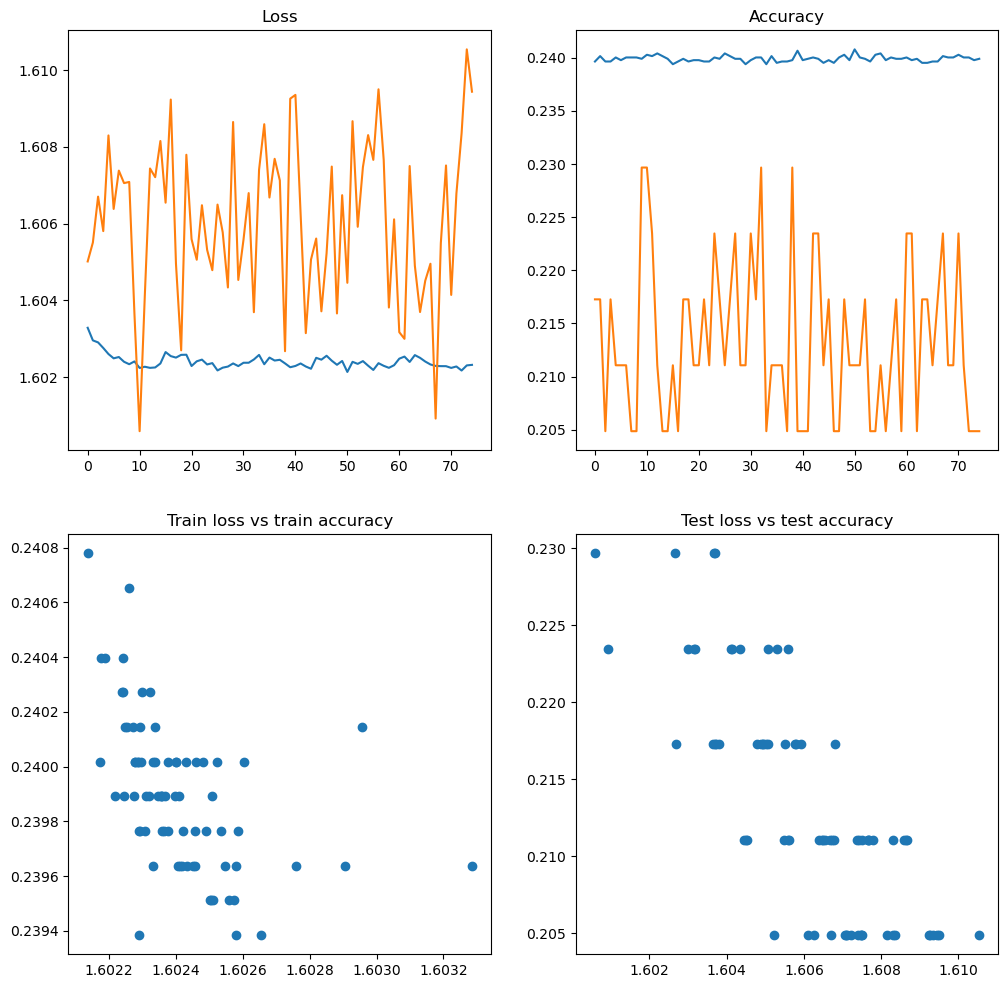

In [209]:
plot_model_results(model_3_results)

In [ ]:
model_3 = VGG11architecture()#.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.01)
m3_start_time = timer()
model_3_results = train(model_3,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=2)
m3_end_time = timer()
print((m3_end_time-m3_start_time)/60)

In [354]:
model_3_results = pd.DataFrame(model_3_results)
model_3_results.tail()

,train_loss,train_acc,test_loss,test_acc
45,1.598840,0.243835,1.598200,0.26000
46,1.598105,0.240009,1.588812,0.26000
47,1.596471,0.247662,1.598865,0.27375
48,1.598373,0.243835,1.596245,0.26000
49,1.600283,0.241922,1.586336,0.27375


In [ ]:
plot_model_results(model_3_results)

In [ ]:
from pathlib import Path
MODEL_PATH = Path("flowers_five_classes")
MODEL_NAME = "vgg11_five_flowers_10_epochs.pth"
RESULT_PATH = MODEL_PATH / "vgg11_summary_results.pickle"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# save the model
torch.save(obj=model_3.state_dict(),
           f=MODEL_NAME)

In [206]:
with open('vgg11_summary_results.pickle', 'wb') as handle:
    pickle.dump(model_3_results, handle)

In [ ]:
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.001)

In [319]:
model_3_results1 = train(model_3,
                         train_dataloader,
                         test_dataloader,
                         optimizer,
                         epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59887 | Train acc: 0.24384 | Test loss: 1.59467 | Test acc: 0.24625
Epoch: 2
Train loss: 1.59811 | Train acc: 0.24575 | Test loss: 1.59400 | Test acc: 0.27375
Epoch: 3
Train loss: 1.59731 | Train acc: 0.24192 | Test loss: 1.60549 | Test acc: 0.24625
Epoch: 4
Train loss: 1.59873 | Train acc: 0.24001 | Test loss: 1.60455 | Test acc: 0.24625
Epoch: 5
Train loss: 1.59758 | Train acc: 0.24575 | Test loss: 1.58801 | Test acc: 0.28750
Epoch: 6
Train loss: 1.59921 | Train acc: 0.24192 | Test loss: 1.60734 | Test acc: 0.23250
Epoch: 7
Train loss: 1.59816 | Train acc: 0.24384 | Test loss: 1.60857 | Test acc: 0.24625
Epoch: 8
Train loss: 1.59766 | Train acc: 0.24384 | Test loss: 1.58852 | Test acc: 0.27375
Epoch: 9
Train loss: 1.60028 | Train acc: 0.24001 | Test loss: 1.58886 | Test acc: 0.28750
Epoch: 10
Train loss: 1.59746 | Train acc: 0.24575 | Test loss: 1.59884 | Test acc: 0.24625
Epoch: 11
Train loss: 1.59793 | Train acc: 0.24575 | Test loss: 1.60312 | Test acc: 0.246

In [324]:
model_3_results1 = pd.DataFrame(model_3_results1)
model_3_results = pd.concat([model_3_results, model_3_results1])
with open('vgg11_summary_results.pickle', 'wb') as handle:
    pickle.dump(model_3_results, handle)

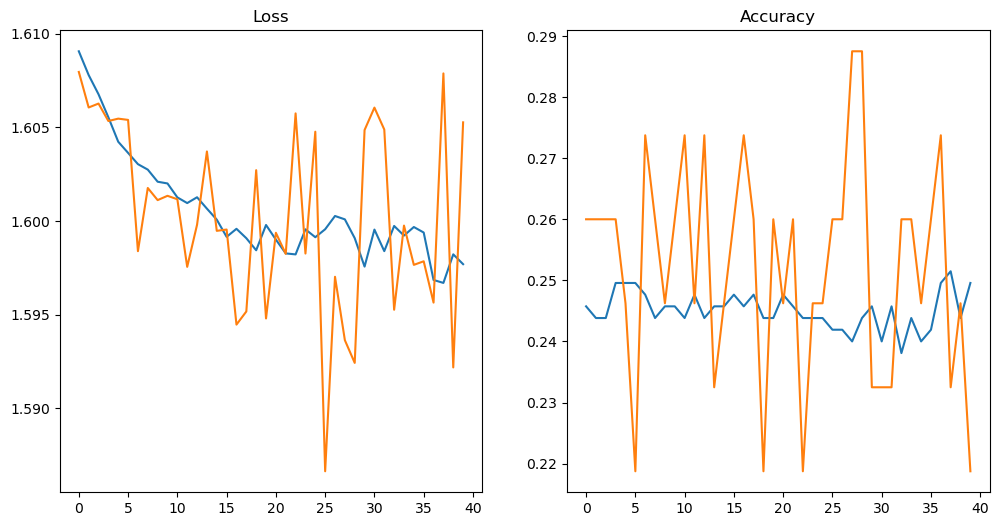

In [317]:
plot_model_results(model_3_results)

In [32]:
MODEL_NAME = "vgg11_five_flowers_10_epochs.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# save the model
torch.save(obj=model_3.state_dict(),
           f=MODEL_SAVE_PATH)

### Model 4: learning rate 0.001

In [325]:
model_4 = VGG11architecture()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.001)

In [326]:
model_4_results = train(model_4,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=50)

model_4_results = pd.DataFrame(model_4_results)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60952 | Train acc: 0.22789 | Test loss: 1.60990 | Test acc: 0.17500
Epoch: 2
Train loss: 1.60944 | Train acc: 0.22789 | Test loss: 1.60945 | Test acc: 0.20250
Epoch: 3
Train loss: 1.60940 | Train acc: 0.22215 | Test loss: 1.60915 | Test acc: 0.21625
Epoch: 4
Train loss: 1.60930 | Train acc: 0.22215 | Test loss: 1.60957 | Test acc: 0.20250
Epoch: 5
Train loss: 1.60908 | Train acc: 0.22598 | Test loss: 1.60910 | Test acc: 0.20250
Epoch: 6
Train loss: 1.60899 | Train acc: 0.22406 | Test loss: 1.60915 | Test acc: 0.20250
Epoch: 7
Train loss: 1.60877 | Train acc: 0.22789 | Test loss: 1.60859 | Test acc: 0.23000
Epoch: 8
Train loss: 1.60873 | Train acc: 0.22406 | Test loss: 1.60918 | Test acc: 0.18875
Epoch: 9
Train loss: 1.60858 | Train acc: 0.22598 | Test loss: 1.60909 | Test acc: 0.17500
Epoch: 10
Train loss: 1.60838 | Train acc: 0.22980 | Test loss: 1.60913 | Test acc: 0.18875
Epoch: 11
Train loss: 1.60835 | Train acc: 0.22598 | Test loss: 1.60840 | Test acc: 0.202

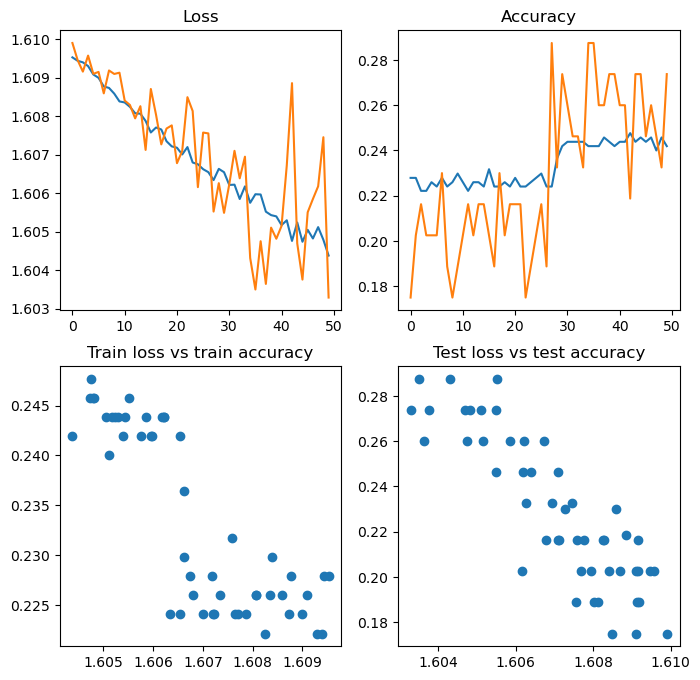

In [342]:
plot_model_results(model_4_results, figsize=8)

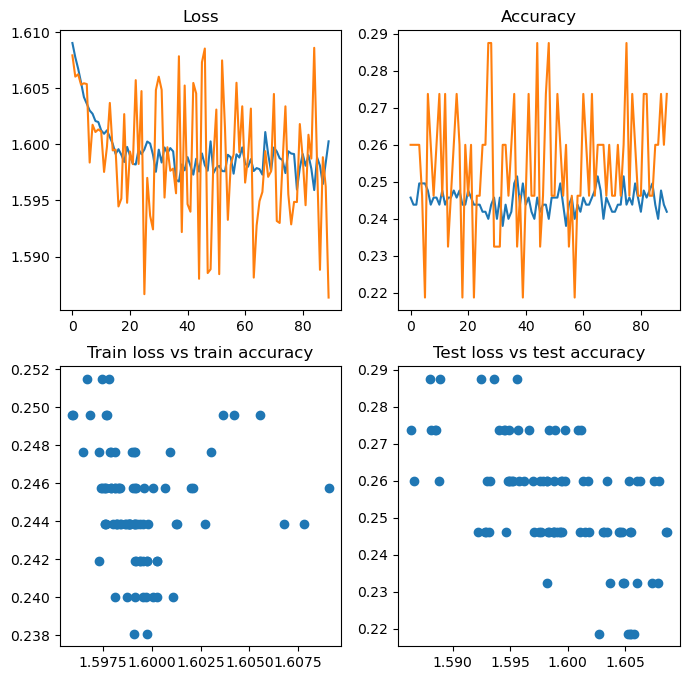

In [346]:
plot_model_results(model_3_results, figsize=8)

### Model 5: changing learning rate

* first 20 epochs learning rate $lr=0.01$
* after 20 epochs move learning rate to $lr=0.001$

In [370]:
model_5 = VGG11architecture()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_5.parameters(),
                            lr=0.01)

In [372]:
m5_start_time = timer()
model_5_results = train(model_5,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=20)
m5_end_time = timer()
print(m5_end_time-m5_start_time)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60751 | Train acc: 0.20877 | Test loss: 1.60953 | Test acc: 0.12500
Epoch: 2
Train loss: 1.60636 | Train acc: 0.22952 | Test loss: 1.61130 | Test acc: 0.13021
Epoch: 3
Train loss: 1.60540 | Train acc: 0.24842 | Test loss: 1.61079 | Test acc: 0.13021
Epoch: 4
Train loss: 1.60438 | Train acc: 0.24711 | Test loss: 1.61251 | Test acc: 0.12500
Epoch: 5
Train loss: 1.60355 | Train acc: 0.24842 | Test loss: 1.61263 | Test acc: 0.13021
Epoch: 6
Train loss: 1.60279 | Train acc: 0.24895 | Test loss: 1.61348 | Test acc: 0.12500
Epoch: 7
Train loss: 1.60205 | Train acc: 0.24842 | Test loss: 1.61310 | Test acc: 0.11979
Epoch: 8
Train loss: 1.60148 | Train acc: 0.24869 | Test loss: 1.61344 | Test acc: 0.13021
Epoch: 9
Train loss: 1.60077 | Train acc: 0.24895 | Test loss: 1.61584 | Test acc: 0.13021
Epoch: 10
Train loss: 1.60039 | Train acc: 0.24895 | Test loss: 1.61465 | Test acc: 0.12500
Epoch: 11
Train loss: 1.59962 | Train acc: 0.24921 | Test loss: 1.61270 | Test acc: 0.140

In [377]:
print((m5_end_time-m5_start_time)/60)

25.993916598616245


In [379]:
optimizer = torch.optim.SGD(model_5.parameters(),
                            lr=0.001)

m5_start_time = timer()
model_5_results1 = train(model_5,
                         train_dataloader,
                         test_dataloader,
                         optimizer,
                         epochs=20)
m5_end_time = timer()
print((m5_end_time-m5_start_time)/60)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59702 | Train acc: 0.24711 | Test loss: 1.62065 | Test acc: 0.12500
Epoch: 2
Train loss: 1.59685 | Train acc: 0.24790 | Test loss: 1.62363 | Test acc: 0.11979
Epoch: 3
Train loss: 1.59679 | Train acc: 0.24842 | Test loss: 1.62207 | Test acc: 0.11458
Epoch: 4
Train loss: 1.59694 | Train acc: 0.24790 | Test loss: 1.62175 | Test acc: 0.13021
Epoch: 5
Train loss: 1.59664 | Train acc: 0.24737 | Test loss: 1.61987 | Test acc: 0.11979
Epoch: 6
Train loss: 1.59658 | Train acc: 0.24737 | Test loss: 1.61788 | Test acc: 0.13021
Epoch: 7
Train loss: 1.59687 | Train acc: 0.24737 | Test loss: 1.62257 | Test acc: 0.11979
Epoch: 8
Train loss: 1.59691 | Train acc: 0.24790 | Test loss: 1.61827 | Test acc: 0.13542
Epoch: 9
Train loss: 1.59656 | Train acc: 0.24895 | Test loss: 1.62301 | Test acc: 0.11458
Epoch: 10
Train loss: 1.59685 | Train acc: 0.24737 | Test loss: 1.61972 | Test acc: 0.12500
Epoch: 11
Train loss: 1.59671 | Train acc: 0.24764 | Test loss: 1.62038 | Test acc: 0.135

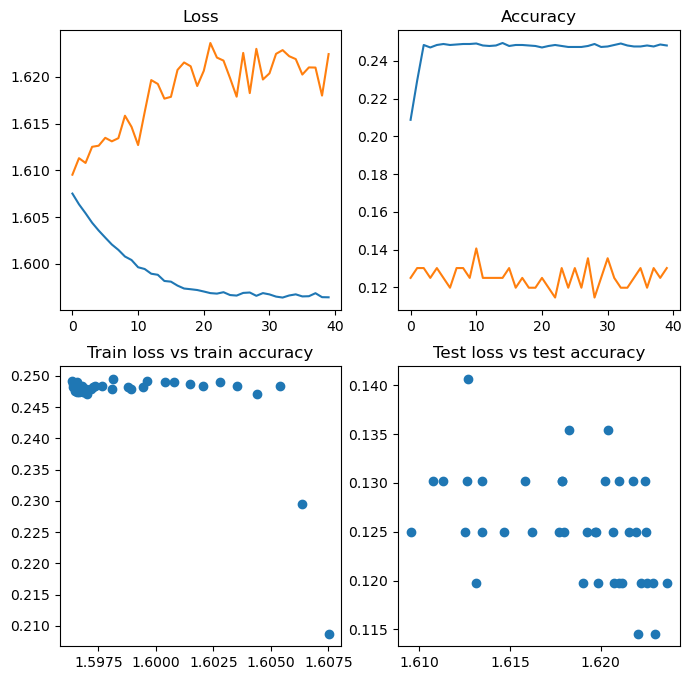

In [383]:
model_5_all_results = pd.concat([
    pd.DataFrame(model_5_results),
    pd.DataFrame(model_5_results1)])
plot_model_results(model_5_all_results, figsize=8)

In [385]:
train_data, test_data = train_test_split(data, test_size=0.05)
other_data, train_data = train_test_split(train_data, test_size=0.25)

In [387]:
m5_start_time = timer()
model_5_results2 = train(model_5,
                         train_dataloader,
                         test_dataloader,
                         optimizer,
                         epochs=10)
m5_end_time = timer()
print((m5_end_time-m5_start_time)/60)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59628 | Train acc: 0.24816 | Test loss: 1.62110 | Test acc: 0.13021
Epoch: 2
Train loss: 1.59659 | Train acc: 0.24685 | Test loss: 1.61356 | Test acc: 0.14062
Epoch: 3
Train loss: 1.59626 | Train acc: 0.24842 | Test loss: 1.62776 | Test acc: 0.11458
Epoch: 4
Train loss: 1.59621 | Train acc: 0.24842 | Test loss: 1.62234 | Test acc: 0.11458
Epoch: 5
Train loss: 1.59641 | Train acc: 0.24790 | Test loss: 1.62199 | Test acc: 0.11979
Epoch: 6
Train loss: 1.59627 | Train acc: 0.24816 | Test loss: 1.62131 | Test acc: 0.13021
Epoch: 7
Train loss: 1.59644 | Train acc: 0.24842 | Test loss: 1.62068 | Test acc: 0.11979
Epoch: 8
Train loss: 1.59640 | Train acc: 0.24790 | Test loss: 1.62175 | Test acc: 0.12500
Epoch: 9
Train loss: 1.59639 | Train acc: 0.24790 | Test loss: 1.61894 | Test acc: 0.13542
Epoch: 10
Train loss: 1.59630 | Train acc: 0.24790 | Test loss: 1.62183 | Test acc: 0.12500
12.987516863883744


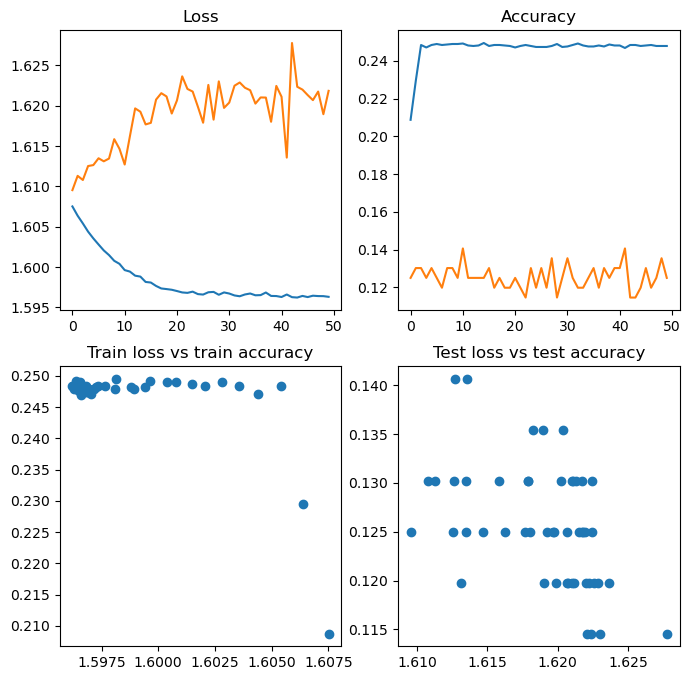

In [395]:
model_5_all_results = pd.concat([
    pd.DataFrame(model_5_results),
    pd.DataFrame(model_5_results1),
    pd.DataFrame(model_5_results2)])
plot_model_results(model_5_all_results, figsize=8)

In [389]:
torch.cuda.is_available()

False

## VGG11 transfer learning -**success**-

1. Load weights
2. Load model with weights
3. Freeze all weights, except last layer
4. Replace classifier
5. Import data and apply proper transformation (e.g. normalization)
6. Create dataloaders


In [49]:
import torchvision

In [ ]:
weights = torchvision.models.VGG11_Weights.IMAGENET1K_V1

In [83]:
model_6 = torchvision.models.vgg11(weights=weights).to(device)

In [85]:
print(next(model_6.parameters()).is_mps)

True


In [86]:
for param in model_6.features.parameters():
  param.requires_grad = False

In [87]:
model_6.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [88]:
model_6.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features = 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features = 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features = 5)).to(device)
model_6.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)

In [89]:
# print(next(model_6.parameters()).is_mps)

In [90]:
from torchvision import transforms

normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalise])

In [91]:
data = datasets.ImageFolder(root="train",
                            transform=manual_transforms, # transform for the data
                            target_transform=None)

In [95]:
class_names = data.classes
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [100]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [101]:
torch.manual_seed(100)
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
len(train_dataloader)

69

In [102]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(),
                             lr=0.0001)

In [103]:
# from torchinfo import summary

# # Print a summary using torchinfo (uncomment for actual output)
# summary(model=model_6, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [104]:
device

'mps'

In [105]:
m6_start_time = timer()
model_6_results = train(model_6,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=5,
                        device=device)
m6_end_time = timer()
print((m6_end_time-m6_start_time)/60)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 0.63463 | Train acc: 0.76411 | Test loss: 0.31496 | Test acc: 0.89211
Epoch: 2
Train loss: 0.11998 | Train acc: 0.95879 | Test loss: 0.30191 | Test acc: 0.89931
Epoch: 3
Train loss: 0.04206 | Train acc: 0.98868 | Test loss: 0.28255 | Test acc: 0.92014
Epoch: 4
Train loss: 0.01110 | Train acc: 0.99864 | Test loss: 0.34931 | Test acc: 0.91567
Epoch: 5
Train loss: 0.01322 | Train acc: 0.99909 | Test loss: 0.28883 | Test acc: 0.90699
2.369918132632544


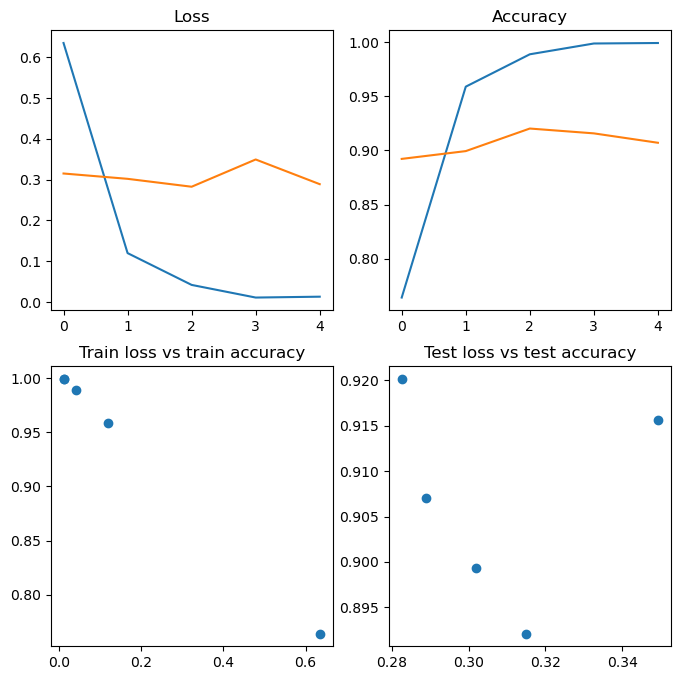

In [117]:
plot_model_results(pd.DataFrame(model_6_results),8)

## Tiny VGG version 2 (archived not-working)

In [ ]:
class TinyVGG2(nn.Module):
  def __init__(self,
               in_feature: int,
               hidden_units: int,
               output_features: int,
               remaining_dimensions: int):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_feature,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*remaining_dimensions*remaining_dimensions,
                  out_features=output_features)
    )

  def forward(self, x):
    return self.classifier(
        self.conv_block2(self.conv_block1(x)))

In [ ]:
model_3 = TinyVGG2(3, 10, 5, 11)
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [ ]:
model_3_results = train(model_3,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=60)

model_3_results_total = pd.DataFrame(model_3_results)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6066 | train_acc: 0.2257 | test_loss: 1.6019 | test_acc: 0.2344
Epoch: 2 | train_loss: 1.6054 | train_acc: 0.2216 | test_loss: 1.5992 | test_acc: 0.2500
Epoch: 3 | train_loss: 1.6047 | train_acc: 0.2285 | test_loss: 1.5969 | test_acc: 0.2500
Epoch: 4 | train_loss: 1.5987 | train_acc: 0.2298 | test_loss: 1.6211 | test_acc: 0.2523
Epoch: 5 | train_loss: 1.6001 | train_acc: 0.2380 | test_loss: 1.5975 | test_acc: 0.2500
Epoch: 6 | train_loss: 1.6053 | train_acc: 0.2190 | test_loss: 1.5977 | test_acc: 0.2500
Epoch: 7 | train_loss: 1.6050 | train_acc: 0.2284 | test_loss: 1.5989 | test_acc: 0.2500
Epoch: 8 | train_loss: 1.6049 | train_acc: 0.2282 | test_loss: 1.5978 | test_acc: 0.2344
Epoch: 9 | train_loss: 1.6052 | train_acc: 0.2162 | test_loss: 1.5975 | test_acc: 0.2500
Epoch: 10 | train_loss: 1.6052 | train_acc: 0.2254 | test_loss: 1.5989 | test_acc: 0.2500
Epoch: 11 | train_loss: 1.6052 | train_acc: 0.2216 | test_loss: 1.5996 | test_acc: 0.2500
Epoch: 12 | train_l

In [ ]:
model_4 = TinyVGG2(3, 10, 5, 11)
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [ ]:
model_4_results = train(model_4,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=60)

model_4_results_total = pd.DataFrame(model_4_results)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6089 | train_acc: 0.2282 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 2 | train_loss: 1.6089 | train_acc: 0.2279 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 3 | train_loss: 1.6089 | train_acc: 0.2287 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 4 | train_loss: 1.6088 | train_acc: 0.2290 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 5 | train_loss: 1.6089 | train_acc: 0.2279 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 6 | train_loss: 1.6089 | train_acc: 0.2279 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 7 | train_loss: 1.6088 | train_acc: 0.2290 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 8 | train_loss: 1.6089 | train_acc: 0.2284 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 9 | train_loss: 1.6089 | train_acc: 0.2287 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 10 | train_loss: 1.6089 | train_acc: 0.2284 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 11 | train_loss: 1.6089 | train_acc: 0.2282 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 12 | train_l

In [ ]:
model_5 = TinyVGG2(3, 10, 5, 11)
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [ ]:
model_5_results = train(model_5,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=60)
model_5_results_total = pd.DataFrame(model_5_results)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6094 | train_acc: 0.1851 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 2 | train_loss: 1.6093 | train_acc: 0.1851 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 3 | train_loss: 1.6093 | train_acc: 0.1857 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 4 | train_loss: 1.6093 | train_acc: 0.1857 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 5 | train_loss: 1.6093 | train_acc: 0.1862 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 6 | train_loss: 1.6092 | train_acc: 0.1857 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 7 | train_loss: 1.6093 | train_acc: 0.1857 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 8 | train_loss: 1.6093 | train_acc: 0.1849 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 9 | train_loss: 1.6093 | train_acc: 0.1851 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 10 | train_loss: 1.6095 | train_acc: 0.1849 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 11 | train_loss: 1.6093 | train_acc: 0.1851 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 12 | train_l

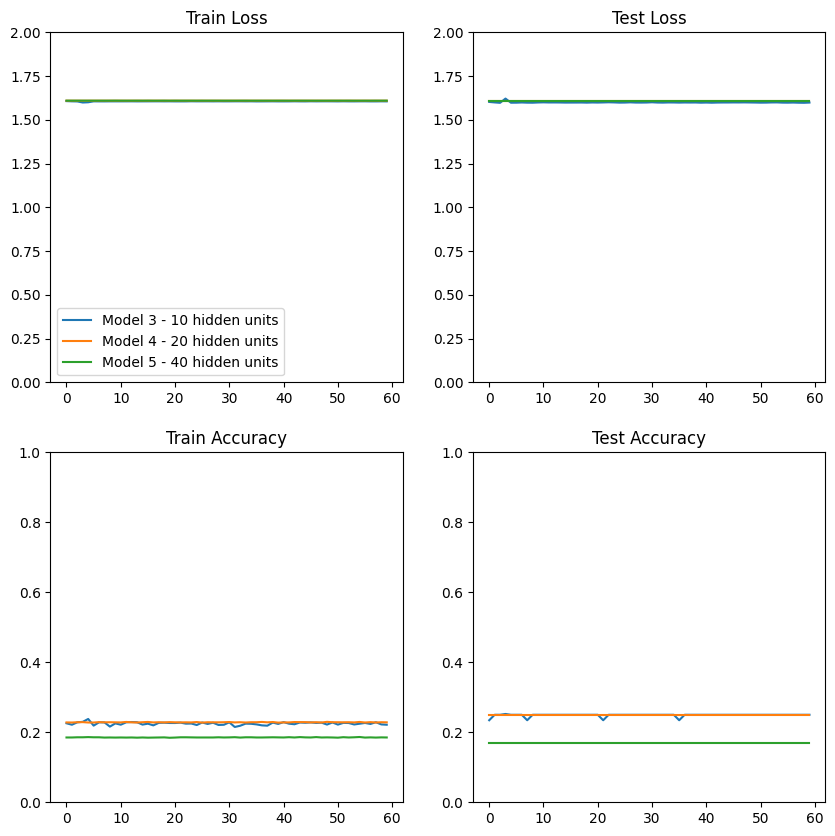

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(range(len(model_3_results_total["train_loss"])), model_3_results_total["train_loss"], label="Model 3 - 10 hidden units")
plt.plot(range(len(model_4_results_total["train_loss"])), model_4_results_total["train_loss"], label="Model 4 - 20 hidden units")
plt.plot(range(len(model_5_results_total["train_loss"])), model_5_results_total["train_loss"], label="Model 5 - 40 hidden units")
plt.legend()
plt.ylim(0, 2)
plt.title("Train Loss")

plt.subplot(2, 2, 2)
plt.plot(range(len(model_3_results_total["train_loss"])), model_3_results_total["test_loss"])
plt.plot(range(len(model_4_results_total["train_loss"])), model_4_results_total["test_loss"])
plt.plot(range(len(model_5_results_total["train_loss"])), model_5_results_total["test_loss"])
plt.ylim(0, 2)
plt.title("Test Loss")

plt.subplot(2, 2, 3)
plt.plot(range(len(model_3_results_total["train_loss"])), model_3_results_total["train_acc"])
plt.plot(range(len(model_4_results_total["train_loss"])), model_4_results_total["train_acc"])
plt.plot(range(len(model_5_results_total["train_loss"])), model_5_results_total["train_acc"])
plt.ylim(0, 1)
plt.title("Train Accuracy");

plt.subplot(2, 2, 4)
plt.plot(range(len(model_3_results_total["train_loss"])), model_3_results_total["test_acc"])
plt.plot(range(len(model_4_results_total["train_loss"])), model_4_results_total["test_acc"])
plt.plot(range(len(model_5_results_total["train_loss"])), model_5_results_total["test_acc"])
plt.ylim(0, 1)
plt.title("Test Accuracy");

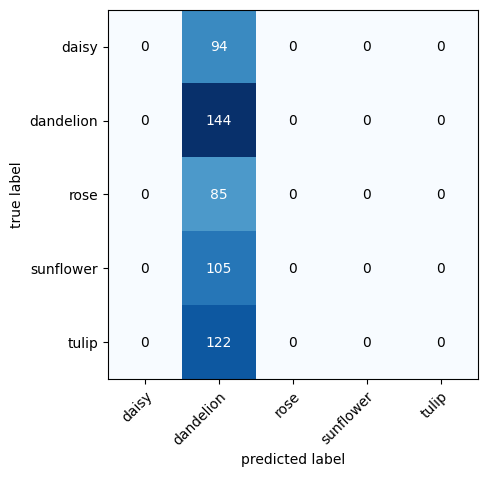

In [ ]:
confusion_matrix_plot(model_3,
                      test_dataloader,
                      class_names)

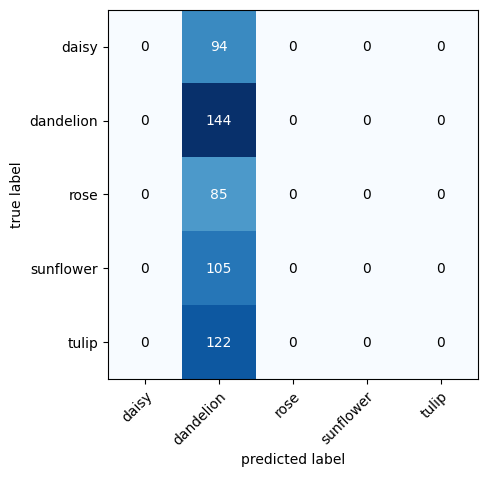

In [ ]:
confusion_matrix_plot(model_4,
                      test_dataloader,
                      class_names)

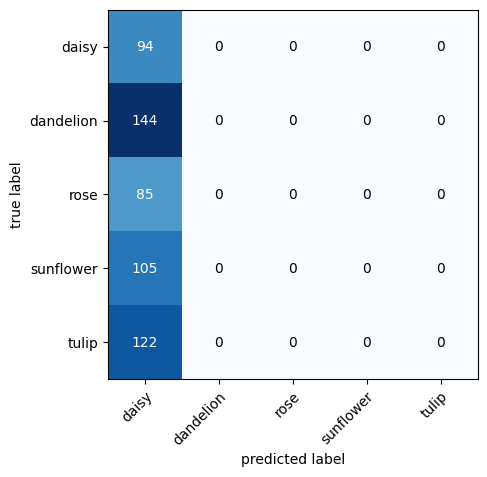

In [ ]:
confusion_matrix_plot(model_5,
                      test_dataloader,
                      class_names)